### Regresión Logística - Pair programming ###

## 1. EDA ##

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


# Estandarización variables numéricas y Codificación variables categóricas
# -----------------------------------------------------------------------------
from sklearn.preprocessing import RobustScaler

# Gestión datos desbalanceados
# ------------------------------------------------------------------------------

from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score

# Para separar los datos en train y test
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

Esto es una vuelta atrás del trabajo para solventar los problemas que hemos tenido con el desbalanceo. Partimos desde el primer EDA que no volvemos a realizar para no duplicar información. Lo único que haremos será omitir el cambio de las variables que consideramos categóricas de "float" a "category", como indicamos más abajo dejamos esa parte del código comentada.

In [2]:
df = pd.read_csv("data/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


En este modelo NO cambiamos las columnas a categóricas.

In [3]:
# columnas_cat = ["used_chip", "repeat_retailer", "online_order", "used_pin_number", "fraud"]
# for columna in columnas_cat:
#     df[columna] = df[columna].astype("category")

Como ahora todas nuestras columnas son numéricas, eliminamos las columnas que consideramos catagóricas de cara a hacer Robust Scaler (utilizamos este método porque tenemos outliers).

In [4]:
numericas = df.select_dtypes(include = np.number)
numericas.drop(["repeat_retailer","used_chip", "online_order", "used_pin_number", "fraud" ], axis = 1, inplace = True)

In [5]:
numericas.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0,57.877857,0.311140,1.945940
1,10.829943,0.175592,1.294219
2,5.091079,0.805153,0.427715
3,2.247564,5.600044,0.362663
4,44.190936,0.566486,2.222767


In [6]:
robust = RobustScaler()

In [7]:
robust.fit(numericas)

RobustScaler()

In [8]:
X_robust = robust.transform(numericas)

In [9]:
numericas_robust = pd.DataFrame(X_robust, columns = numericas.columns)
numericas_robust.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0,2.19108,-0.224744,0.585071
1,0.03943,-0.269055,0.182947


Unimos el dataframe original con los datos estandarizados.

In [10]:
df[numericas_robust.columns] = numericas_robust
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.191080,-0.224744,0.585071,1.0,1.0,0.0,0.0,0.0
1,0.039430,-0.269055,0.182947,1.0,0.0,0.0,0.0,0.0
2,-0.223026,-0.063254,-0.351702,1.0,0.0,0.0,1.0,0.0
3,-0.353069,1.504177,-0.391840,1.0,1.0,0.0,1.0,0.0
4,1.565134,-0.141273,0.755879,1.0,1.0,0.0,1.0,0.0


Guardamos el dataframe modificado para utilizarlo en los diferentes modelos.

In [11]:
df.to_pickle("data/df_robust.pkl")

Vamos a proceder a realizar el desbalanceo de la VR, dado que ya sabemos que hemos tenido problemas con la generación de nulos vamos a hacerlo antes de dividir los datos en Train y Test.

In [12]:
y = df['fraud']
X = df.drop('fraud', axis=1)

In [13]:
# iniciamos el método
os_us = SMOTETomek()

# ajustamos el modelo
X_train_res, y_train_res = os_us.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [15]:
# comprobemos como han quedado ahora las categorías después del ajuste

print (f"Distribution before resampling \n {y_train.value_counts()}" )
print("..............................................................")
print (f"Distribución después del ajuste \n {y_train_res.value_counts()}")

Distribution before resampling 
 0.0    638802
1.0     61198
Name: fraud, dtype: int64
..............................................................
Distribución después del ajuste 
 0.0    912561
1.0    912561
Name: fraud, dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [17]:
y_train_res.shape

(1825122,)

In [18]:
X_train_res.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
dtype: int64

In [19]:
df_balanceo_sin_cat = pd.concat([y_train_res, X_train_res], axis = 1)

In [20]:
df_balanceo_sin_cat.isnull().sum()

fraud                             0
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
dtype: int64

In [21]:
df_balanceo_sin_cat['fraud'].value_counts()

0.0    912561
1.0    912561
Name: fraud, dtype: int64

In [22]:
df_balanceo_sin_cat.to_pickle('data/df_balanceo_sin_cat.pkl')

# PRIMER MODELO SOLO APLICANDO ROBUST SCALER Y VARIABLES SIN MODIFICAR

In [23]:
# separamos los datos en X e y

X1 = df.drop("fraud", axis = 1)
y1 = df["fraud"]

In [24]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [25]:
# definimos la regresión logistica

log_reg_esta = LogisticRegression(n_jobs=-1, max_iter = 1000)

# ajustamos el modelo
log_reg_esta.fit(x_train1,y_train1)

# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train_esta = log_reg_esta.predict(x_train1)

# obtenemos las predicciones para el conjunto de test
y_pred_test_esta = log_reg_esta.predict(x_test1)

In [26]:
train_df_esta = pd.DataFrame({'Real': y_train1, 'Predicted': y_pred_train_esta, 'Set': ['Train']*len(y_train1)})
test_df_esta  = pd.DataFrame({'Real': y_test1,  'Predicted': y_pred_test_esta,  'Set': ['Test']*len(y_test1)})
resultados = pd.concat([train_df_esta,test_df_esta], axis = 0)
resultados.head()

,Real,Predicted,Set
760648,0.0,0.0,Train
79333,0.0,0.0,Train
771344,0.0,0.0,Train
179102,0.0,0.0,Train
75318,0.0,0.0,Train


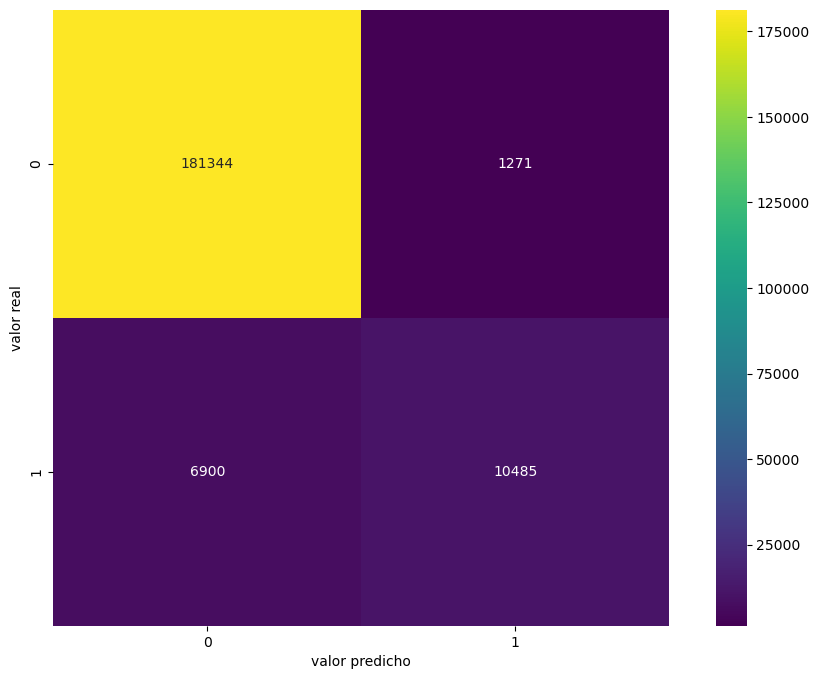

In [27]:
# MATRIZ DE CORRELACIÓN PARA DATOS CODIFICADOS Y  ESTANDARIZADOS

mat_lr1 = confusion_matrix(y_test1, y_pred_test_esta)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr1, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

# SEGUNDO MODELO CON ROBUST SCALER Y DESBALANCEO

In [28]:
# separamos los datos en X e y

X2 = df_balanceo_sin_cat.drop("fraud", axis = 1)
y2 = df_balanceo_sin_cat["fraud"]

In [29]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 1)

In [30]:
# definimos la regresión logistica

log_reg = LogisticRegression(n_jobs=-1, max_iter = 1000)

# ajustamos el modelo
log_reg.fit(x_train2,y_train2)

# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train = log_reg_esta.predict(x_train2)

# obtenemos las predicciones para el conjunto de test
y_pred_test = log_reg_esta.predict(x_test2)

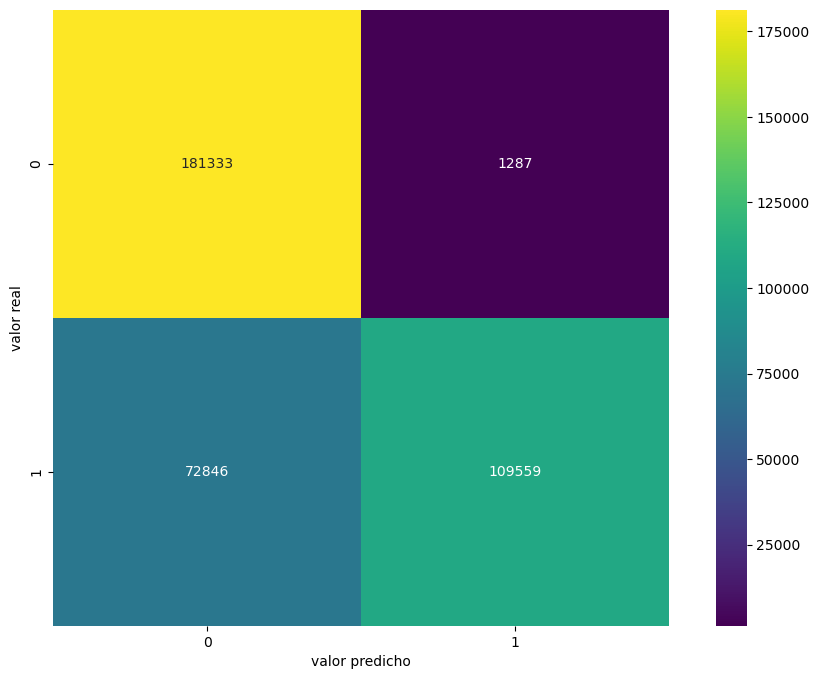

In [31]:
# MATRIZ DE CORRELACIÓN PARA DATOS CODIFICADOS Y SIN ESTANDARIZAR

mat_lr2 = confusion_matrix(y_test2, y_pred_test)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr2, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

In [32]:
# vamos a hacernos una función para sacar las métricas igual que hicimos con al regresión lineal.


def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [33]:
results_logistic_esta = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Regresión logistica sin cat")
results_logistic_esta

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.959145,0.891885,0.603106,0.719605,0.698456,test,Regresión logistica sin cat
1,0.958630,0.892370,0.599646,0.717293,0.695899,train,Regresión logistica sin cat


In [34]:
results_logistic = metricas(y_test2, y_pred_test, y_train2, y_pred_train, "Regresión logistica balanceado sin cat")
results_logistic

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.796910,0.988389,0.600636,0.747203,0.593726,test,Regresión logistica balanceado sin cat
1,0.796969,0.988672,0.600883,0.747474,0.593961,train,Regresión logistica balanceado sin cat


In [35]:
resultados_sin_cat = pd.concat([results_logistic, results_logistic_esta], axis = 0)
resultados_sin_cat

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.796910,0.988389,0.600636,0.747203,0.593726,test,Regresión logistica balanceado sin cat
1,0.796969,0.988672,0.600883,0.747474,0.593961,train,Regresión logistica balanceado sin cat
0,0.959145,0.891885,0.603106,0.719605,0.698456,test,Regresión logistica sin cat
1,0.958630,0.892370,0.599646,0.717293,0.695899,train,Regresión logistica sin cat


Mirando los resultados, concluimos que el modelo donde no regulamos el desbalanceo es mejor que el modelo en el que si lo hacemos. Dado que no es un buen modelo, utilizaremos este archivo para generar nuevos modelos utilizando Decision Tree y Random Forest.